# Electrical Properties Tomography

## Assumptions regarding unhealthy tissue and healthy tissue conductivity

# H-EPT & CR-EPT

In [3]:
import numpy as np
import cv2
import h5py
from scipy import ndimage
from copy import deepcopy
from scipy.ndimage import sobel, generic_gradient_magnitude, gaussian_filter
import scipy
import os
import numpy as np
import cv2
import h5py
import matplotlib.pyplot as plt 
from copy import deepcopy
from scipy.ndimage import sobel, generic_gradient_magnitude, gaussian_filter
import pandas as pd

# %matplotlib notebook
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)
                
def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.set_title(f'data[{ax.index}]')
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])
    ax.set_title(f'data[{ax.index}]')

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])
    ax.set_title(f'data[{ax.index}]')

In [4]:
class Scan:
    def __init__(self, model, variant, directory):
        self.model = model
        self.variant = variant
        self.file_segmentation = directory + model + "/" + model + "_" + variant + ".h5"
        self.file_hept = directory + model + "/" + model + "_" + variant + ".hept.h5"
        self.file_crept = directory + model + "/" + model + "_" + variant + ".crept.h5"
        
        with h5py.File(self.file_hept, "r") as f_hept, h5py.File(self.file_crept, "r") as f_crept, h5py.File(self.file_segmentation, "r") as f_segmentation:
            assert( 'sigma' in f_hept )
            self.hept_conductivity = f_hept['sigma'][()]
            assert( 'sigma' in f_crept )
            self.crept_conductivity = f_crept['sigma'][()]
            assert( 'mat' in f_segmentation )
            self.segmentation = f_segmentation['mat'][()]

In [5]:
noisy_data_directory = 'snr200/'
noiseless_data_directory = 'noiseless/'

models = [
        "female_71",    
        "female_252_w",
        "female_328", 
        "female_147", 
        "female_151_w", 
        "female_290",   
        "female_329", 
        "female_76",  
        "female_86", 
        "female_247_w", 
        "female_323",   
        "female_379", 
        "male_150",  
        "male_269",
        "male_93",     
        "male_272",
        "male_184",   
        "male_196",  
        "male_80" 
]

X = np.array(models)

In [6]:
def findBiggestSlice(ndarray):
    shape_x, shape_y, shape_z = np.shape(ndarray)
    first = None
    last = None
    for x in range(0, shape_x):
        cur_slice = ndarray[x,:,:]
        if first is None and np.any(cur_slice):
            first = x
        if first is not None and last is None and ~np.any(cur_slice):
            last = x-1
    if first is None:
        return shape_x//2
    if last is None:
        last = shape_x -1
    return first+((last-first)//2)

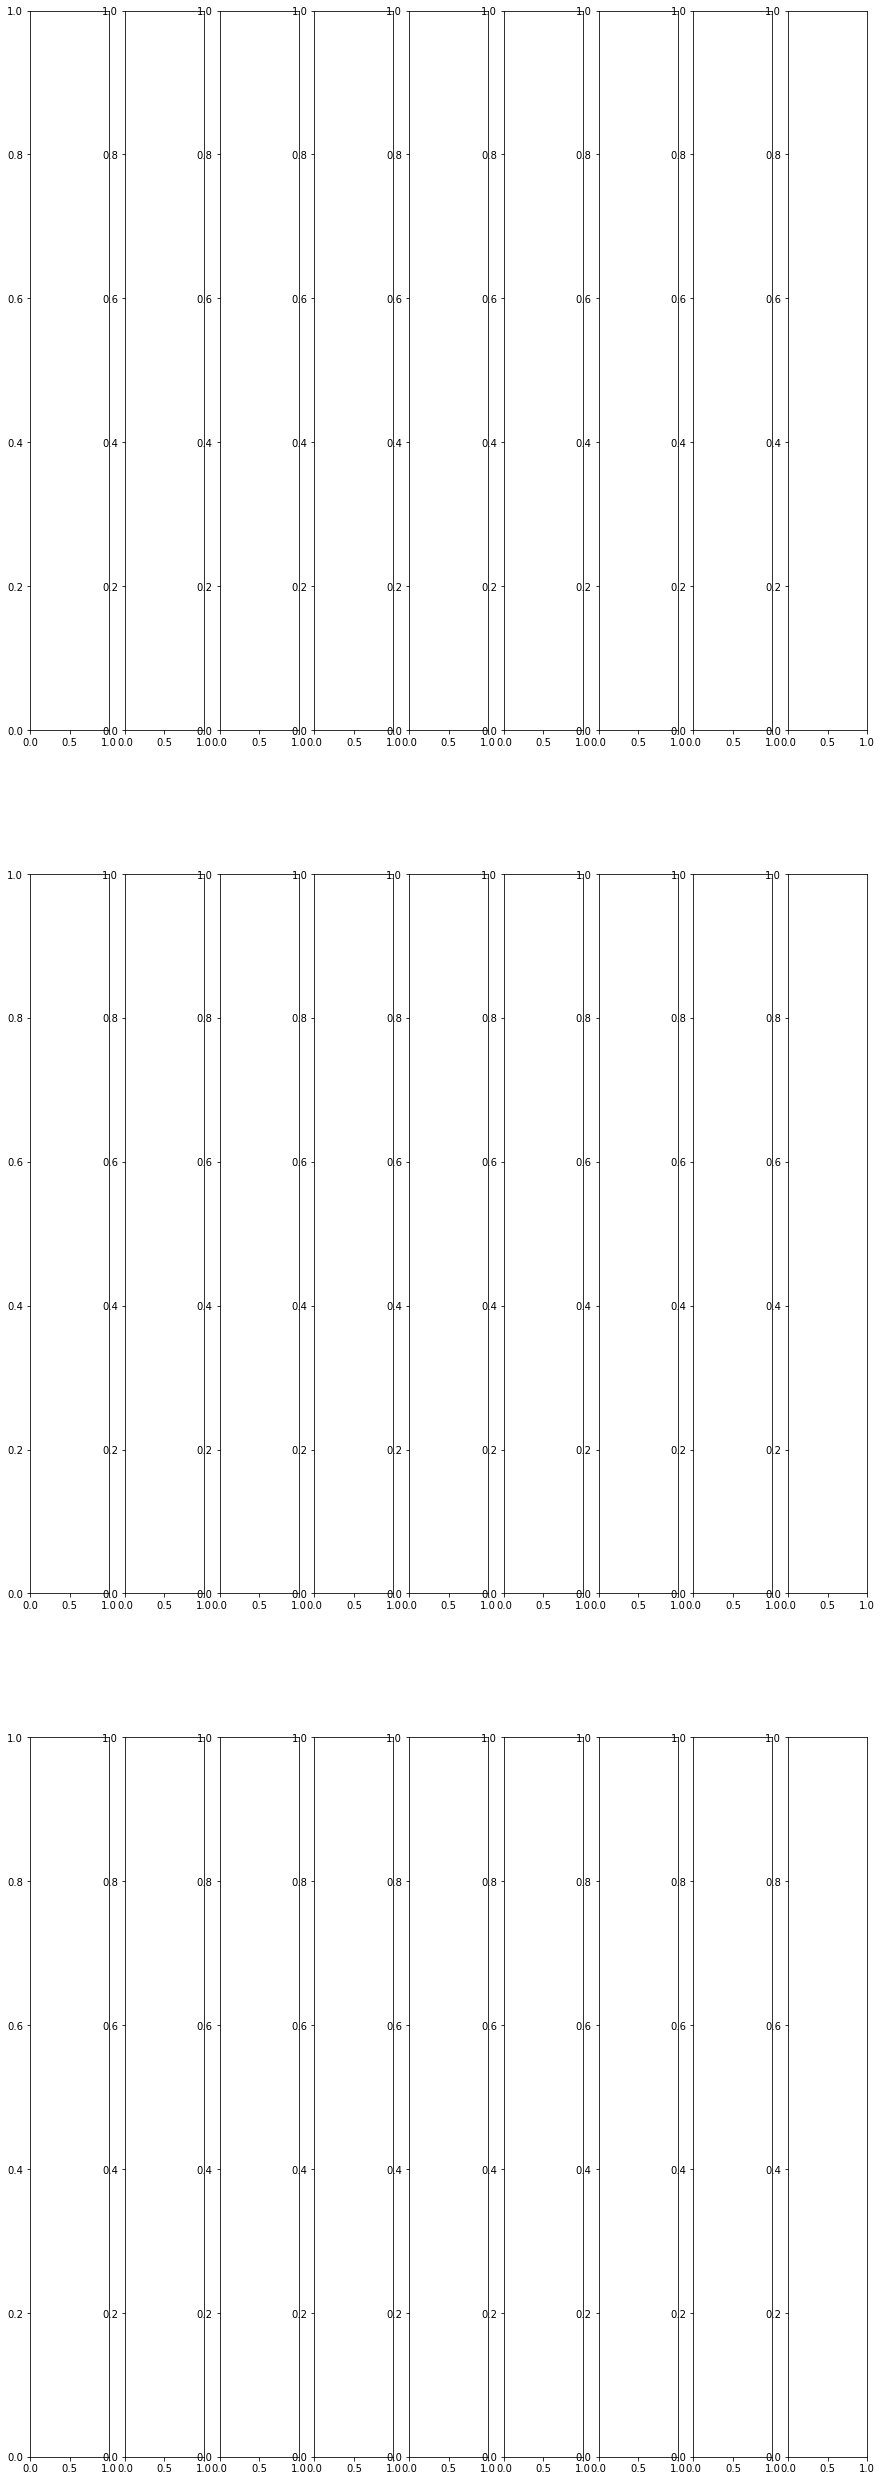

In [7]:
directory = noiseless_data_directory
fig, axis = plt.subplots(3, 9, figsize=(3*5, 9*5))
def visualise_head(model, directory):
    #visualize all variants segmentation, hept, crept
    for variant in range(0,10):
        v = str(variant)
        s = scan(model, v, directory)
#         axis[0].imshow(deepcopy(pmap.scan.segmentation[biggest_slice_index2, :, :]))
#         axis[0].set_title('Ground truth')
        
#         axis[1].clear()
#         axis[1].imshow(deepcopy(enriched_scan.map[biggest_slice_index2, :, :]))
#         axis[1].set_title('Probability map')
                
#         axis[2].imshow(deepcopy(localization[biggest_slice_index2, :, :]))
#         axis[2].set_title('Localization')

#         axis[3].imshow(deepcopy(prediction[biggest_slice_index, :, :]*2 + (copied_segmentation==anomaly_code)[biggest_slice_index, :, :]))
#         axis[3].set_title('Biggest intersecting slice\nCutoff: ' + str(np.round(cutoff_threshold,2)) + ', jaccard = ' + str(np.round(jaccard,2)))

#         axis[4].imshow(deepcopy(prediction[biggest_slice_index2, :, :]*2 + (copied_segmentation==anomaly_code)[biggest_slice_index2, :, :]))
#         axis[4].set_title('Biggest slice')
    pass

#noiseless and noisy example of a head

In [ ]:
# multi slice viewer inspecting a specific head+variant segmentacija + conductivity

# Estimating noise
## Simulating the reconstruction error
### H-EPT error propagation due to an assumption of the model being correct at tissue boundaries
## Using multiple views of the same data

In [8]:
def crop_area(ndarr, x, y, z, n):
    return ndarr[x - (n//2): x + (n//2) + 1, y - (n//2): y + (n//2) + 1, z - (n//2): z + (n//2) + 1]

lookup = dict()
lookup[0] = 0
for i in range(1, 150000000, 1):
    lookup[i] = np.log2(i)

class ProbabilityMap:
    def __init__(self, scan, load_from_file=""):
        self.scan = scan
        if(not load_from_file):
            self.agreeability = self.agreeability_error()
            self.agreeability_map = self.agreeability / np.nanmax(self.agreeability)
            self.map = self.model_invalidity_error() * 0.1 + self.agreeability_map * 0.9
        else:
            self.map = np.load(os.path.join(load_from_file, "enriched_features",scan.model + "_" + scan.variant + ".npy"))

    def agreeability_error(self):
        tmp = np.abs(self.scan.hept_conductivity - self.scan.crept_conductivity)
        self.distsave = deepcopy(tmp)
        tmpc = deepcopy(tmp)
        
        shape_x, shape_y, shape_z = np.shape(tmpc)

        new_agreeability = np.zeros(np.shape(tmpc))

        for i in range(0, shape_x):
            for j in range(0, shape_y):
                for k in range(0, shape_z):
                    if(~np.isnan(tmpc[i,j,k])):
                        new_agreeability[i, j, k] = lookup[ (int)( (tmpc[i, j, k]/0.5) * 500) ]

        new_agreeability = 1 - new_agreeability/np.nanmax(new_agreeability)
        self.agreemap = deepcopy(new_agreeability)
        return new_agreeability

    def model_invalidity_error(self):
        # get borders
        code_segmentation = deepcopy(self.scan.segmentation)
        anomaly_code = np.nanmax(np.unique(code_segmentation))

        code_segmentation[code_segmentation == anomaly_code] = white_matter #pretend we dont know where the anomaly is
        
        codes = np.unique(code_segmentation)
        boundaries = np.zeros(np.shape(code_segmentation))
        boundaries[()] = np.nan
        for code in codes:
            segment_for_code = (code_segmentation == code)
            temp_borders = ndimage.binary_dilation(segment_for_code, iterations=2) - segment_for_code.astype(int)
            boundaries[temp_borders == 1] = temp_borders[temp_borders == 1]

        # compute propagation through savitzky-golay filter
        boundaries_copy = deepcopy(boundaries)
        self.border_copy1 = deepcopy(boundaries)
        
        shape_x, shape_y, shape_z = np.shape(boundaries)
        filtered_boundaries = np.zeros(shape=np.shape(boundaries))
        
        filtered_boundaries[filtered_boundaries == 0] = np.nan

        for i in range(savitzky_golay_kernel_size//2, shape_x - savitzky_golay_kernel_size//2 - 1):
            for j in range(savitzky_golay_kernel_size//2, shape_y - savitzky_golay_kernel_size//2 - 1):
                for k in range(savitzky_golay_kernel_size//2, shape_z - savitzky_golay_kernel_size//2 - 1):
                    cropped_area = crop_area(boundaries, i, j, k, savitzky_golay_kernel_size)
                    filtered_boundaries[i,j,k] = np.nansum(cropped_area*kernel)
                    
        filtered_boundaries[code_segmentation != white_matter] = np.nan # check only white matter including anomaly
        
        self.propagated_boundaries = deepcopy(filtered_boundaries)
        
        error_propagation = np.abs(filtered_boundaries)/np.nanmax(filtered_boundaries)
        
        model_uncertainty = deepcopy(1 - error_propagation)
        model_uncertainty[((code_segmentation == white_matter))&(boundaries_copy == 1)] = 0
        return model_uncertainty  

KeyboardInterrupt: 

In [ ]:
def localize(pmap, cutoff_threshold, k_half, probab_threshold, voxels_within_cube, file_prefix="", visualise=False, split_iteration=None):
    copied_segmentation = deepcopy(pmap.scan.segmentation)

    anomaly_code = np.nanmax(np.unique(pmap.scan.segmentation))

    localization = np.zeros(np.shape(pmap.scan.hept_conductivity))
    full_k = k_half*2+1
    wm_const = 0.292
    cond_to_loca = deepcopy(pmap.scan.hept_conductivity)
    cond_to_loca[pmap.map<probab_threshold] = np.nan
    cond_to_loca[(pmap.scan.segmentation!=anomaly_code) & (pmap.scan.segmentation!=4)] = np.nan

    shape_x, shape_y, shape_z = np.shape(pmap.scan.hept_conductivity)
    for i in range(full_k//2, shape_x-full_k//2 - 1):
        for j in range(full_k//2, shape_y-full_k//2 - 1):
            for k in range(full_k//2, shape_z-full_k//2 - 1):
                cropped_area = crop_area(cond_to_loca, i, j, k, full_k)
                if(np.sum(~np.isnan(cropped_area))>voxels_within_cube):
                    localization[i,j,k] = np.max([np.nanmedian(cropped_area) - wm_const*1.1, 0])

    localization[np.isnan(localization)] = 0
    prediction = deepcopy(localization>cutoff_threshold)
    jaccard = np.sum((copied_segmentation==anomaly_code)&prediction)/(np.sum(((copied_segmentation==anomaly_code)|prediction)) or 42)

    distribution_of_loc = deepcopy(localization)
    dist_of_noise = distribution_of_loc[pmap.scan.segmentation != anomaly_code]
    dist_of_anomaly = distribution_of_loc[pmap.scan.segmentation == anomaly_code]

    skip_nan_noise = dist_of_noise.flatten()[~np.isnan(dist_of_noise)]
    skip_nan_anomaly = dist_of_anomaly.flatten()[~np.isnan(dist_of_anomaly)]
    
    if(visualise):
        biggest_slice_index = findBiggestIntersectingSlice(prediction, (pmap.scan.segmentation==anomaly_code))
        biggest_slice_index2 = findBiggestSlice((pmap.scan.segmentation==anomaly_code))
        axis[0].imshow(deepcopy(pmap.scan.segmentation[biggest_slice_index2, :, :]))
        axis[0].set_title('Ground truth')
        
        axis[1].clear()
        axis[1].imshow(deepcopy(enriched_scan.map[biggest_slice_index2, :, :]))
        axis[1].set_title('Probability map')
                
        axis[2].imshow(deepcopy(localization[biggest_slice_index2, :, :]))
        axis[2].set_title('Localization')

        axis[3].imshow(deepcopy(prediction[biggest_slice_index, :, :]*2 + (copied_segmentation==anomaly_code)[biggest_slice_index, :, :]))
        axis[3].set_title('Biggest intersecting slice\nCutoff: ' + str(np.round(cutoff_threshold,2)) + ', jaccard = ' + str(np.round(jaccard,2)))

        axis[4].imshow(deepcopy(prediction[biggest_slice_index2, :, :]*2 + (copied_segmentation==anomaly_code)[biggest_slice_index2, :, :]))
        axis[4].set_title('Biggest slice')
# save the image as a file at the location
#         plt.savefig('./' + file_prefix + '_localization_comparison_' + pmap.scan.model + "_" + pmap.scan.variant + '.png')

# Example

## Before

In [ ]:
scan = Scan('female_328', '3', snr200_dir)
enriched_scan = ProbabilityMap(scan, './')
enriched_scan.map = np.ones(np.shape(enriched_scan.map)) # we trust every voxel as if it were correct

localize(enriched_scan, 0.06, 3, 0.5, 25, 'demo', True)

## After

In [ ]:
scan = Scan('female_328', '3', snr200_dir)
enriched_scan = ProbabilityMap(scan, './')

localize(enriched_scan, 0.06, 3, 0.5, 25, 'demo', True)

### Cutoff values

In [ ]:
fig, ax = plt.subplots(1, 2)
biggest_slice_index = findBiggestSlice((scan.segmentation==31))

In [ ]:
cut_off = 0

prediction = deepcopy(localization_testing>cut_off)
ax[0].imshow(scan.segmentation[biggest_slice_index,:,:])
ax[2].imshow(prediction)